# Identify a MHW

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
#import regionate as reg

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sst_trop_ds.zarr'))

In [3]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    sst = ds_sst.sst.load()

In [4]:
sst

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
array([[[26.528534, 26.537628, 26.55774 , ...,       nan,       nan,
               nan],
        [26.541504, 26.543457, 26.555145, ...,       nan,       nan,
               nan],
        [26.55774 , 26.549927, 26.557068, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[26.528534, 26.537628, 26.55774 , ...,       nan,       nan,
               nan],
        [26.541504, 26.543457, 26.555145, ...,       nan,       nan,
               nan],
        [26.55774 , 26.549927, 26.557068, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

# Compute daily/monthly climatology and anomaly

In [5]:
#resample to daily to get rid of diurnal cycle
sst_resampled = sst.resample(time='D').mean()

In [6]:
#daily clim
#with dask.config.set(**{'array.slicing.split_large_chunks': True}):

clim = sst_resampled.groupby('time.dayofyear').mean('time')
#clim_std = sst_resampled.groupby('time.dayofyear').std('time')
anom = sst_resampled.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst_resampled.groupby('time.month').mean('time')
#mo_clim_std = sst_resampled.groupby('time.month').std('time')
mo_anom = sst_resampled.groupby('time.month') - mo_clim

In [7]:
anom

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
array([[[-0.3977909 , -0.4098568 , -0.41076088, ...,         nan,
                 nan,         nan],
        [-0.408041  , -0.42844772, -0.41965866, ...,         nan,
                 nan,         nan],
        [-0.40283775, -0.43808556, -0.44677544, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.38329506, -0.41287804, -0.41893768, ...,         nan,
                 nan,         nan],
        [-0.3805771 , -0.40377045, -0.3980465 , ...,         nan,
                 nan,         nan],
        [-0.37295532, -0.38967705, -0.39601326, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 264 265 266 267 268 269 270 271

In [8]:
anom_fl = anom.sel(latitude=slice(22, 31), longitude=slice(-90, -72))
clim_fl = clim.sel(latitude=slice(22, 31), longitude=slice(-90, -72))

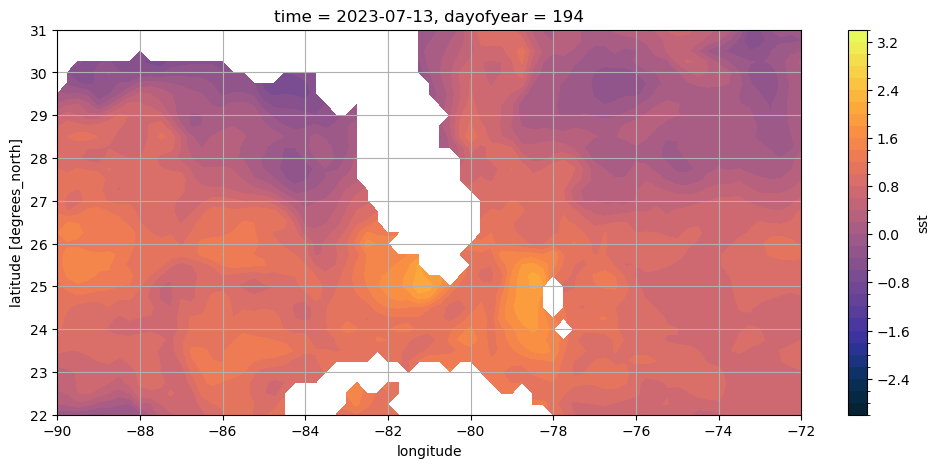

In [9]:
plt.figure(figsize=(12,5))
anom_fl.sel(time='2023-07-13', method='nearest').plot.contourf(levels=np.arange(-3, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
plt.grid();

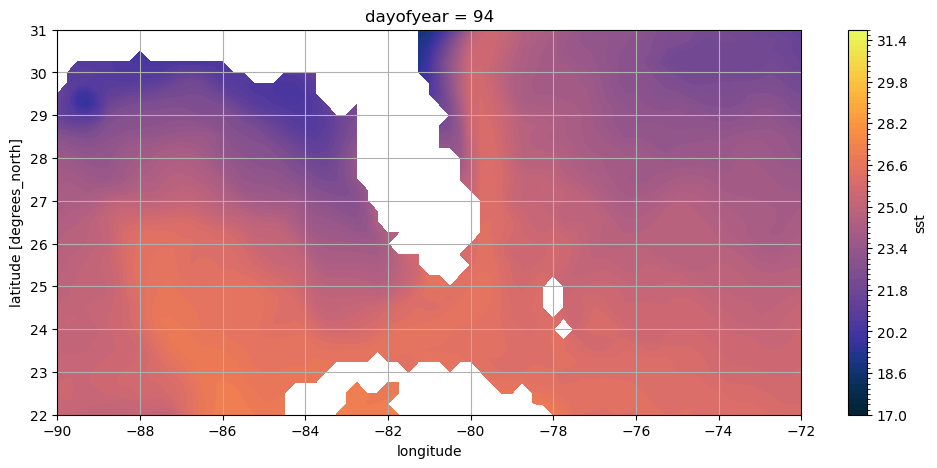

In [14]:
plt.figure(figsize=(12,5))
clim_fl.isel(dayofyear=93).plot.contourf(levels=np.arange(17, 32, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
plt.grid();

In [16]:
idxmax_anom = anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).idxmax(dim='time', skipna=True)
idxmax_clim = clim_fl.isel(dayofyear=slice(93, 125)).idxmax(dim='dayofyear', skipna=True)

In [20]:
argmax_anom = anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).fillna(0.).argmax(dim='time')
argmax_clim = clim_fl.isel(dayofyear=slice(93,125)).fillna(0.).argmax(dim='dayofyear')

In [21]:
argmax_clim

<xarray.DataArray 'sst' (latitude: 37, longitude: 73)>
array([[31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       ...,
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31]])
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -72.5 -72.25 -72.0

In [22]:
argmax_anom.values.max()

30

In [23]:
argmax_clim.max().values

array(31)

In [24]:
mask = anom_fl[0].isnull()

/tmp/ipykernel_2007/1634276531.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


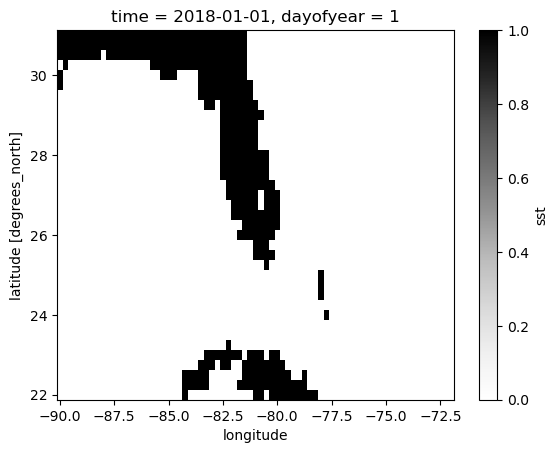

In [25]:
cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap)

/tmp/ipykernel_2007/3382194161.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


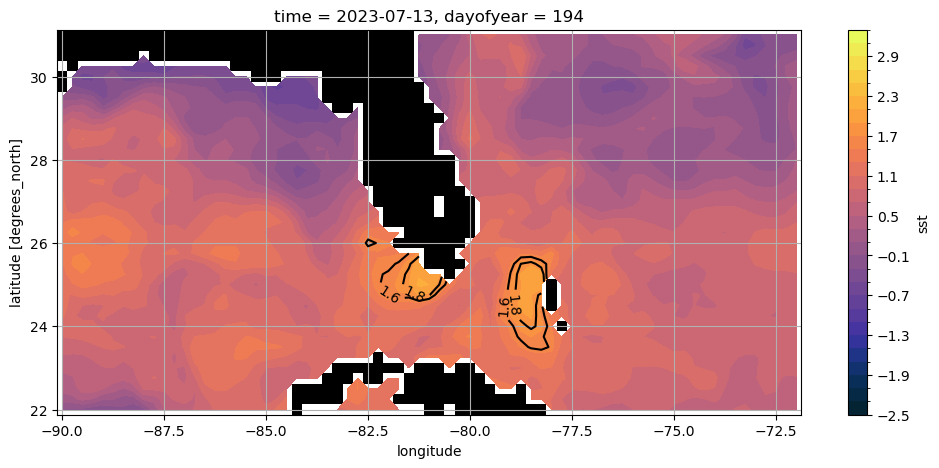

In [26]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap, add_colorbar=False)

anom_fl.sel(time='2023-07-13', method='nearest').plot.contourf(levels=np.arange(-2.5, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = anom_fl.sel(time='2023-07-13', method='nearest').plot.contour(levels=[1.6, 1.8], colors='k')
plt.clabel(c)
plt.grid();

/tmp/ipykernel_2007/2750899400.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


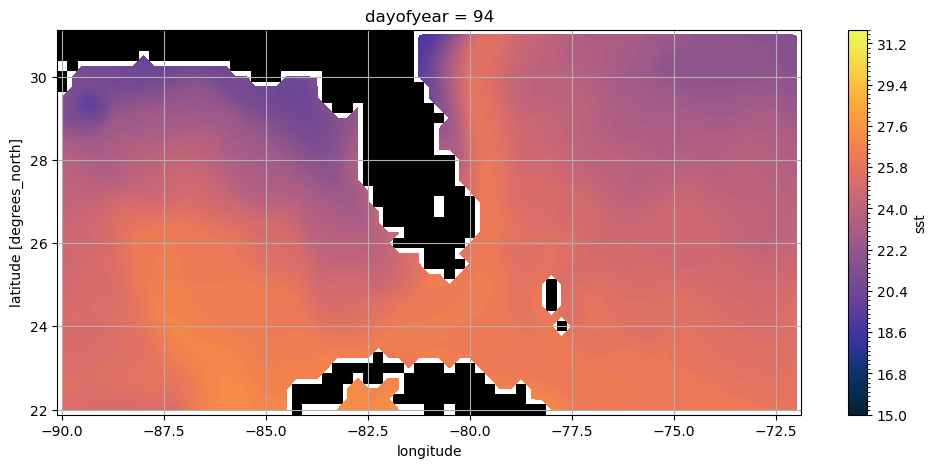

In [27]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap, add_colorbar=False)

clim_fl.isel(dayofyear=93).plot.contourf(levels=np.arange(15, 32, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
plt.grid();

# Movie

In [89]:
#insert datetime object of same length as `dayofyear` coord in order for movie to run
x = np.arange('2222-01', '2223-01-02', dtype='datetime64[D]')

In [46]:
x.shape

(366,)

In [55]:
clim_ds = clim_fl.to_dataset()

In [56]:
clim_ds['time'] = x

In [59]:
clim_ds

<xarray.Dataset>
Dimensions:    (latitude: 37, longitude: 73, dayofyear: 366, time: 366)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -72.5 -72.25 -72.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * time       (time) datetime64[ns] 2222-01-01 2222-01-02 ... 2223-01-01
Data variables:
    sst        (dayofyear, latitude, longitude) float32 25.38 25.34 ... 21.91

In [90]:
sst_newcoords = clim_ds.assign_coords(time=x).drop('dayofyear').rename({'dayofyear':'time'})
sst = sst_newcoords.sst

In [91]:
sst

<xarray.DataArray 'sst' (time: 366, latitude: 37, longitude: 73)>
array([[[25.377245, 25.336836, 25.306631, ..., 26.717651, 26.658083,
         26.527847],
        [25.425833, 25.426651, 25.402071, ..., 26.752869, 26.7124  ,
         26.708   ],
        [25.437952, 25.454666, 25.463081, ..., 26.653334, 26.648867,
         26.659311],
        ...,
        [      nan,       nan,       nan, ..., 22.954851, 22.890112,
         22.799622],
        [      nan,       nan,       nan, ..., 22.833902, 22.81273 ,
         22.734621],
        [      nan,       nan,       nan, ..., 22.711647, 22.71855 ,
         22.692808]],

       [[25.34052 , 25.296652, 25.248001, ..., 26.652529, 26.615175,
         26.49034 ],
        [25.387568, 25.384493, 25.35222 , ..., 26.695755, 26.681534,
         26.67642 ],
        [25.404322, 25.421844, 25.419226, ..., 26.635263, 26.626997,
         26.639143],
...
        [      nan,       nan,       nan, ..., 23.016825, 22.968956,
         22.868534],
        [      nan,       nan,       nan, ..., 22.864117, 22.8426  ,
         22.826397],
        [      nan,       nan,       nan, ..., 22.778576, 22.761684,
         22.795046]],

       [[24.846497, 24.810762, 24.833601, ..., 26.403841, 26.410454,
         26.421768],
        [24.871475, 24.866379, 24.94975 , ..., 26.4345  , 26.437391,
         26.530508],
        [24.873026, 24.873781, 24.968857, ..., 26.40448 , 26.381945,
         26.462532],
        ...,
        [      nan,       nan,       nan, ..., 22.065048, 21.989113,
         21.90596 ],
        [      nan,       nan,       nan, ..., 22.089373, 21.989122,
         21.835112],
        [      nan,       nan,       nan, ..., 22.096384, 22.024065,
         21.909815]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2222-01-01 2222-01-02 ... 2223-01-01

In [72]:
from xmovie import Movie
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [95]:
import cmocean

def contour_surf(da, fig, tt, *args, **kwargs):
    ax = fig.subplots()
    theta_levs = np.arange(15,35,0.5)
    
    #mask out land w/o cartopy
    cmap = plt.cm.get_cmap("Greys")
    cmap.set_bad('red', 1.)
    mask.plot(cmap=cmap, add_colorbar=False)
    
    Cf = da.isel(time=tt).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True, extend='neither')
    ax.grid()

    return ax, Cf

(<Axes: title={'center': 'time = 2222-01-01'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <matplotlib.contour.QuadContourSet at 0x7f62832c0f10>)

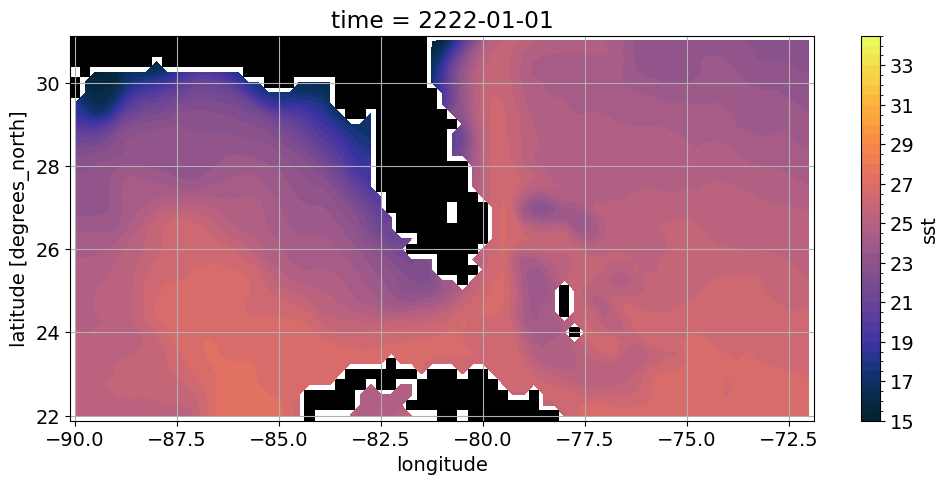

In [96]:
fig = plt.figure(figsize=(12, 5))

contour_surf(sst, fig, 0)

In [97]:
sst = Movie(sst, contour_surf, input_check=False)

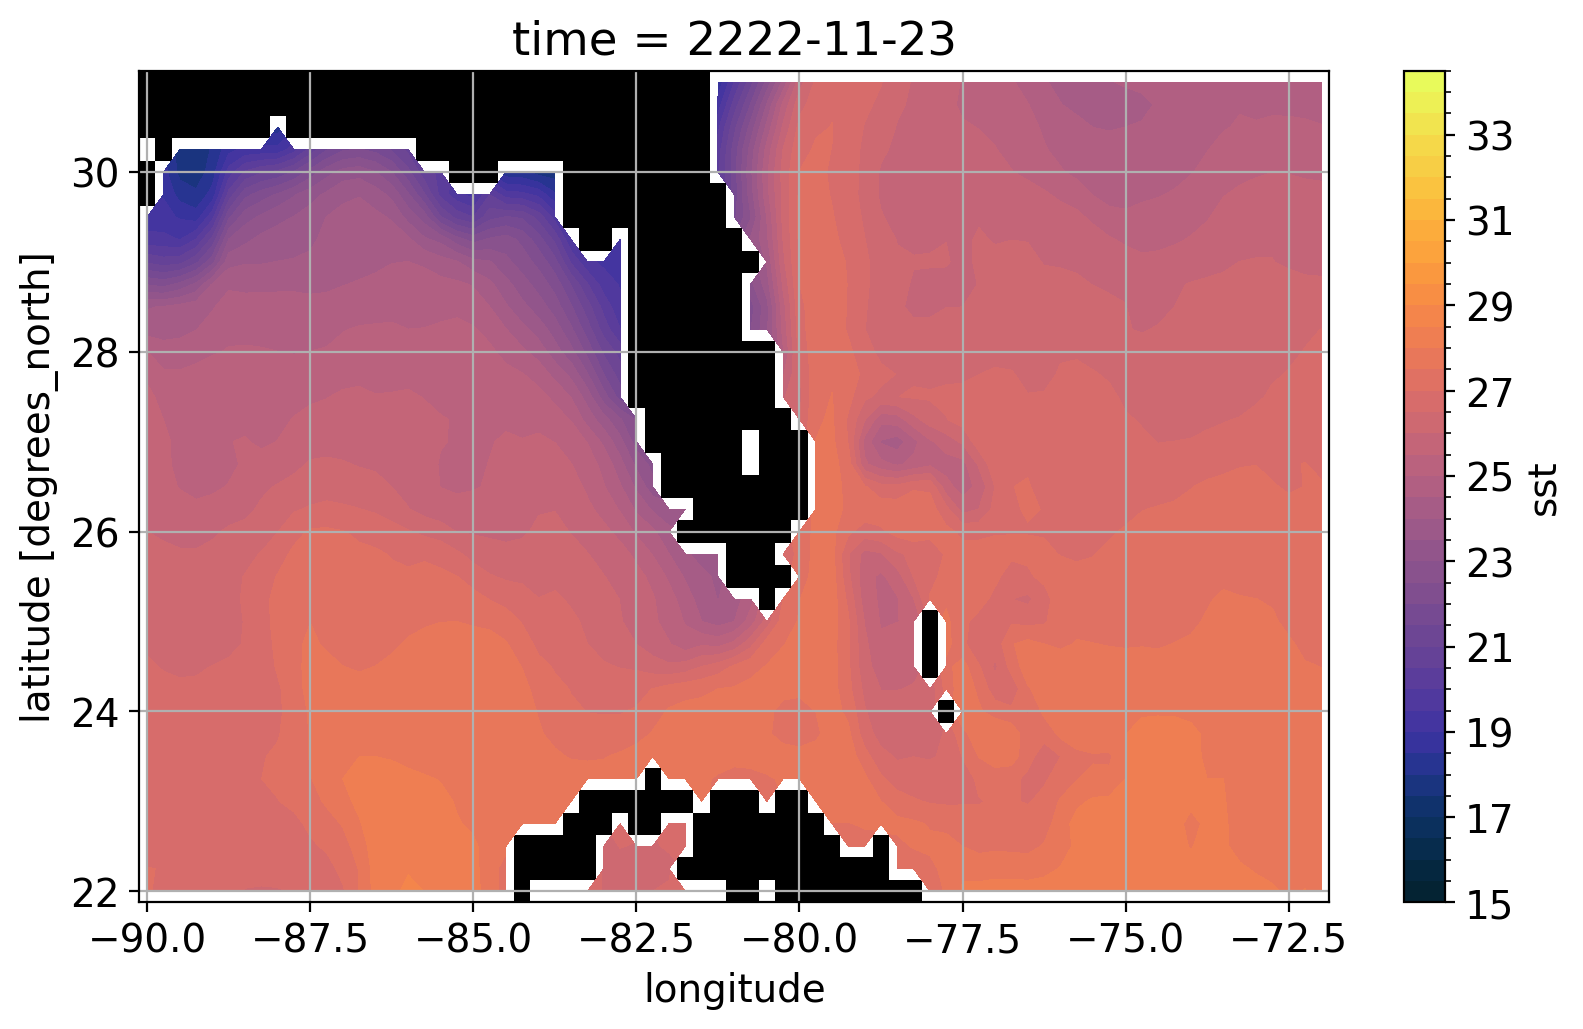

In [98]:
sst.preview(-40)

In [ ]:
#save sst movie
sst.save('sst_clim.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/366 [00:00<?, ?it/s]

In [134]:
import cmocean

def contour_max(da, fig, tt, *args, **kwargs):
    ax = fig.subplots()
    
    Cf = da.isel(time=tt).plot.contour(colors='k', levels=34.52, 
                                                                ax=ax, add_colorbar=True)
    ax.grid()

    return ax, Cf

(<Axes: title={'center': 'quantile = 0.99, time = 2018-01-01'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <matplotlib.contour.QuadContourSet at 0x7feeeda3c5e0>)

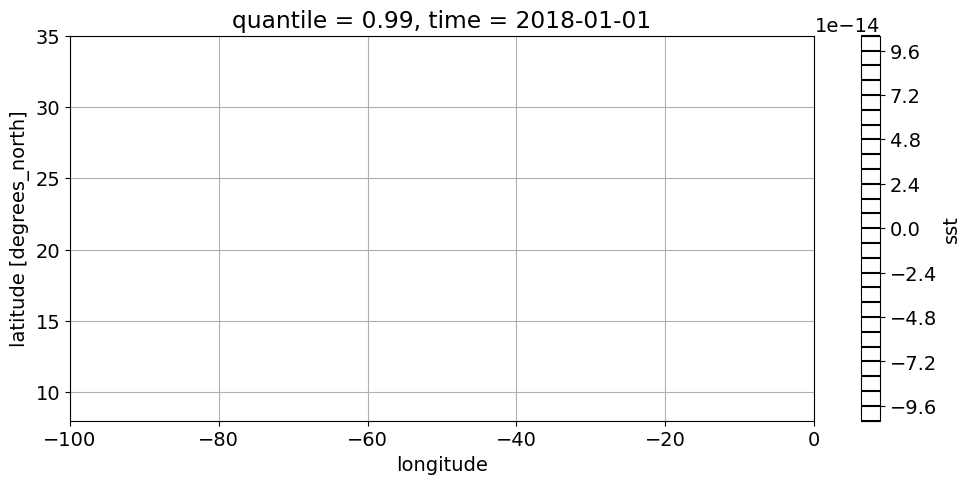

In [135]:
fig = plt.figure(figsize=(12, 5))

contour_max(loaded_maxt, fig, 0)

In [136]:
sst_max = Movie(loaded_maxt, contour_max, input_check=False)

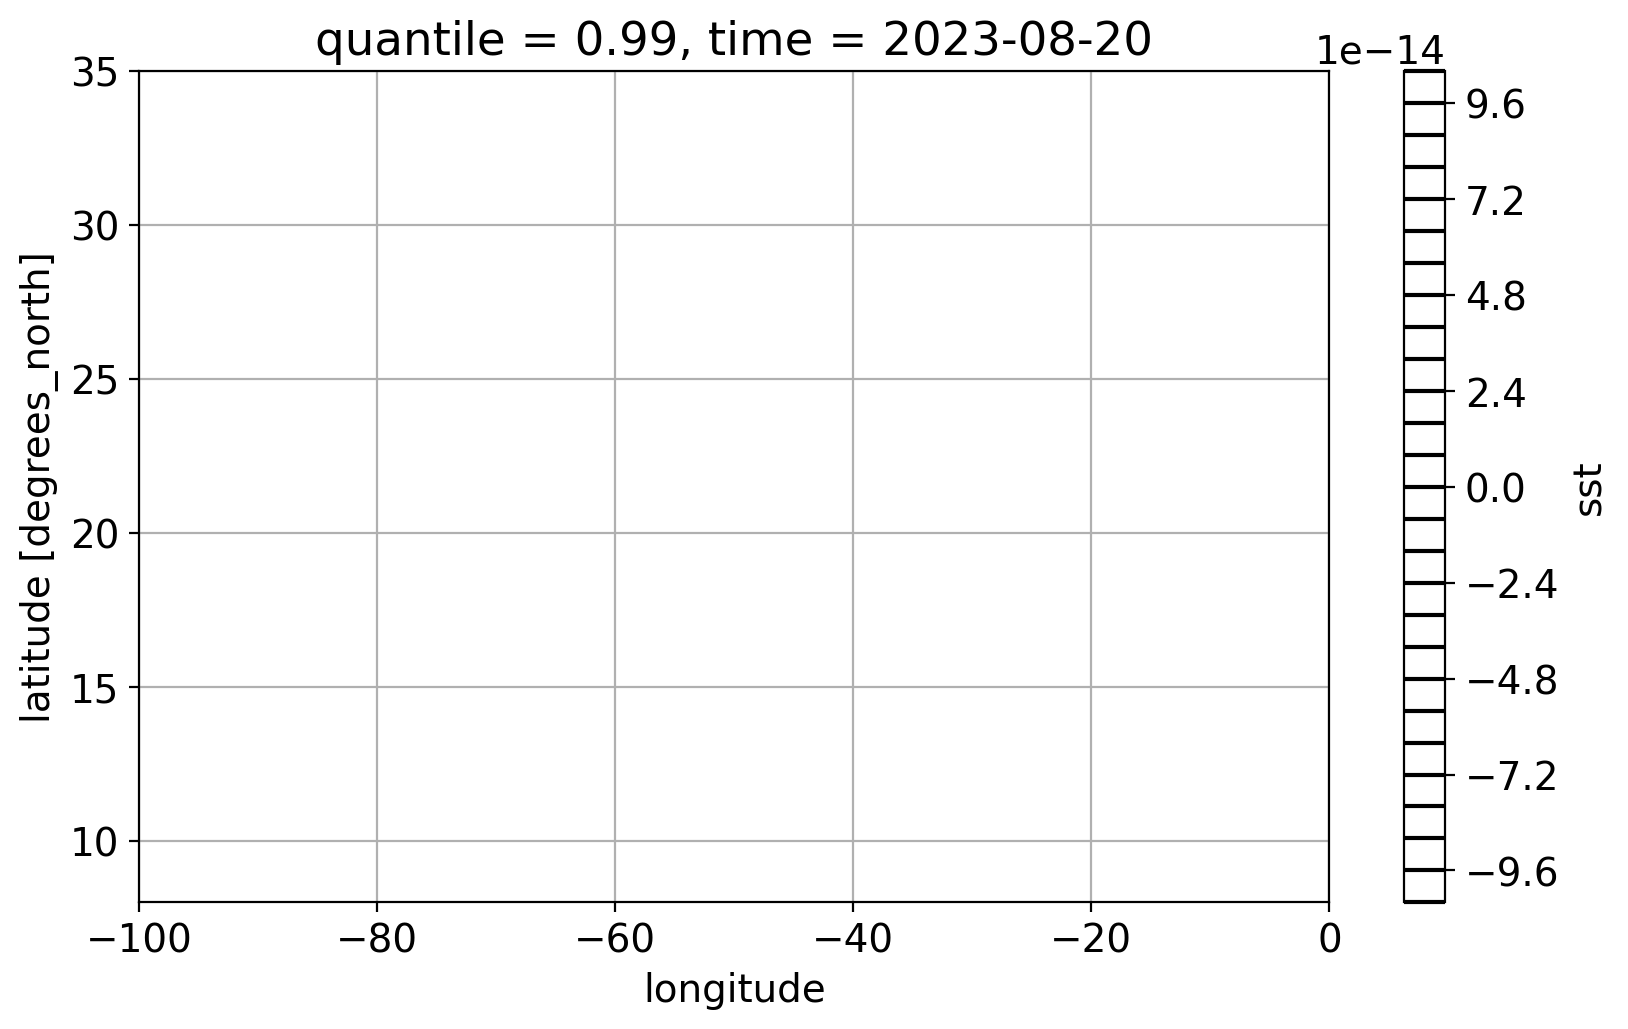

In [137]:
sst_max.preview(-35)

# Find when/where max temp in both percentiles exist

- Max SST in 99$^{th}$ percentile = 34.52 $^{\circ}$C
- Max SST in 95$^{th}$ percentile = 33.59 $^{\circ}$C

In [23]:
resampled99 = above_thr99.resample(time='D').mean()
resampled95 = above_thr95.resample(time='D').mean()

In [24]:
loaded_sst99 = resampled99#.compute()
loaded_sst95 = resampled95#.compute()

In [25]:
loaded_sst95

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    quantile   float64 0.95
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28

In [5]:
idxmax = sst.idxmax(dim='time', skipna=True)

In [6]:
idxmax

<xarray.DataArray 'time' (latitude: 109, longitude: 401)>
array([['2023-05-15T22:00:00.000000000', '2023-05-24T22:00:00.000000000',
        '2023-05-24T22:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2023-05-15T22:00:00.000000000', '2023-05-16T22:00:00.000000000',
        '2023-05-22T22:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2023-05-16T22:00:00.000000000', '2023-05-16T22:00:00.000000000',
        '2023-05-16T22:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       [                          'NaT',                           'NaT',
                                  'NaT', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       [                          'NaT',                           'NaT',
                                  'NaT', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       [                          'NaT',                           'NaT',
                                  'NaT', ...,
                                  'NaT',                           'NaT',
                                  'NaT']], dtype='datetime64[ns]')
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0

In [7]:
argmax = sst.fillna(0.).argmax(dim='time')

In [8]:
argmax

<xarray.DataArray 'sst' (latitude: 109, longitude: 401)>
array([[47062, 47278, 47278, ...,     0,     0,     0],
       [47062, 47086, 47230, ...,     0,     0,     0],
       [47086, 47086, 47086, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]])
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0

In [9]:
argmax.values.max()

50278

In [10]:
sst.time[50278]

<xarray.DataArray 'time' ()>
array('2023-09-26T22:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2023-09-26T22:00:00
Attributes:
    long_name:  time

In [11]:
sst.isel(time=50278).max().values

array(34.57821655)

In [12]:
lat_max = sst.isel(time=50278).fillna(0.).argmax(dim=['latitude', 'longitude'])

In [13]:
lat_max

{'latitude': <xarray.DataArray 'sst' ()>
 array(7)
 Coordinates:
     time     datetime64[ns] 2023-09-26T22:00:00,
 'longitude': <xarray.DataArray 'sst' ()>
 array(113)
 Coordinates:
     time     datetime64[ns] 2023-09-26T22:00:00}

In [14]:
sst[50278, 7, 113]

<xarray.DataArray 'sst' ()>
array(34.578217, dtype=float32)
Coordinates:
    latitude   float32 9.75
    longitude  float32 -71.75
    time       datetime64[ns] 2023-09-26T22:00:00

In [15]:
sst.latitude[7]

<xarray.DataArray 'latitude' ()>
array(9.75, dtype=float32)
Coordinates:
    latitude  float32 9.75
Attributes:
    long_name:  latitude
    units:      degrees_north

In [16]:
sst.longitude[113]

<xarray.DataArray 'longitude' ()>
array(-71.75, dtype=float32)
Coordinates:
    longitude  float32 -71.75

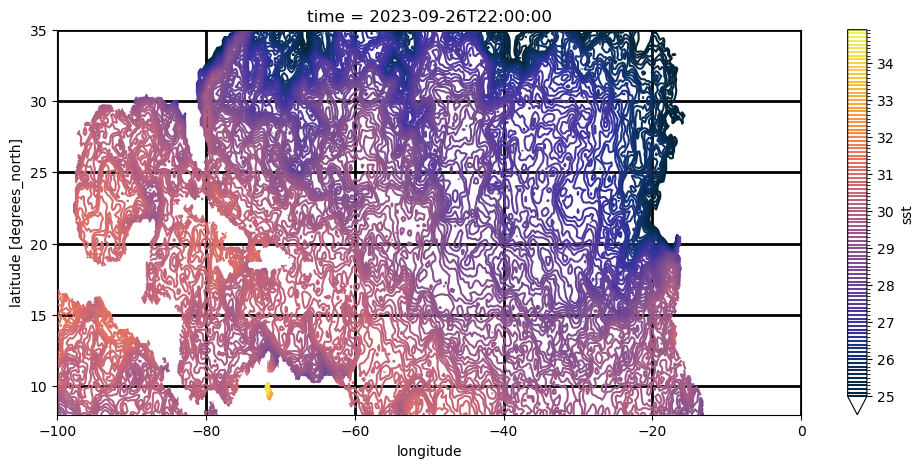

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
theta_levs = np.arange(25, 35, 0.1)
c = sst.isel(time=50278).plot.contour(levels=theta_levs, colors=cmocean.cm.thermal, add_colorbar=True, ax=ax)
#c = sst.isel(time=50278).plot.contourf(levels=theta_levs, colors=cmocean.cm.thermal, add_colorbar=True, ax=ax)
c.collections[-2].set_color('green')
c.collections[-2].set_linewidth(5)
#plt.clabel(c)
plt.grid(color='k', linewidth=2)

# Identify - from Henri's nb

In [28]:
ds_sst.longitude

<xarray.DataArray 'longitude' (longitude: 401)>
array([-100.  ,  -99.75,  -99.5 , ...,   -0.5 ,   -0.25,    0.  ],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0

In [27]:
0.25/2

0.125

In [38]:
lat_c = ds_sst.latitude.values + 0.125
lon_c = ds_sst.longitude.values + 0.125

In [39]:
sst_cc = ds_sst.assign_coords({'longitude_c':lon_c, 'latitude_c':lat_c})

In [40]:
sst_cc

<xarray.Dataset>
Dimensions:      (latitude: 109, longitude: 401, time: 50309, longitude_c: 401,
                  latitude_c: 109)
Coordinates:
  * latitude     (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude    (longitude) float32 -100.0 -99.75 -99.5 ... -0.5 -0.25 0.0
  * time         (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
  * longitude_c  (longitude_c) float32 -99.88 -99.62 -99.38 ... -0.125 0.125
  * latitude_c   (latitude_c) float32 8.125 8.375 8.625 ... 34.62 34.88 35.12
Data variables:
    sst          (time, latitude, longitude) float32 26.53 26.54 ... nan nan

In [41]:
grid = Grid(sst_cc, coords = {'X' : {'center':'longitude', 'right':'longitude_c'},
                           'Y' : {'center':'latitude', 'right':'latitude_c'},
                           'T' : {'center':'time'}},
           periodic=['X'])

In [42]:
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   longitude --> right
  * right    longitude_c --> center
Y Axis (not periodic, boundary=None):
  * center   latitude --> right
  * right    latitude_c --> center
T Axis (not periodic, boundary=None):
  * center   time

In [18]:
area = ds_sst.latitude * ds_sst.longitude

In [20]:
import regionate as reg

In [22]:
reg.grid_boundaries_from_mask()

<module 'regionate' from '/srv/conda/envs/notebook/lib/python3.10/site-packages/regionate/__init__.py'>

In [23]:
def masked_area(grid, mask):
    return (mask * area).sum(['xh', 'yh'])

def large_contiguous_regions(grid, mask, cutoff=(370e3)**2):
    lon_c, lat_c = reg.grid_boundaries_from_mask(grid, mask)
    regions = {}
    for r in range(len(i)):
        rmask = reg.mask_from_grid_boundaries(lon_c[r], lat_c[r], grid)
        if masked_area(grid, rmask) >= cutoff:
            regions[r] = {
                'r': r,
                'lon_c': lon_c[r],
                'lat_c': lat_c[r],
                'mask': rmask
            }
    return regions

In [24]:
large_contiguous_regions(grid, loaded_sst95)

ValueError: Horizontal grid axes ('X', 'Y') must be either both symmetric or both non-symmetric (by MOM6 conventions).